In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle
import plotly.express as px

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   

In [3]:
sessions = lfp_startup.get_session_ids('nhp', 'SA', 'WCST')
sessions = sessions[:41]

In [5]:
import warnings
warnings.filterwarnings('ignore')

chosen_ones = np.empty(len(sessions))
chosen_twos = np.empty(len(sessions))
has_twos = np.empty((len(sessions)))
for i, session in enumerate(sessions):
    behavior_file = spike_general.get_behavior_path(subject, session)
    behavior_data = pd.read_csv(fs.open(behavior_file))
    valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]  
    chosen_one, chosen_two, has_two = behavioral_utils.get_chosen_two_out_of_has_two(valid_beh)
    chosen_ones[i] = chosen_one
    chosen_twos[i] = chosen_two
    has_twos[i] = has_two

chosen_zeros = has_twos - chosen_ones - chosen_twos


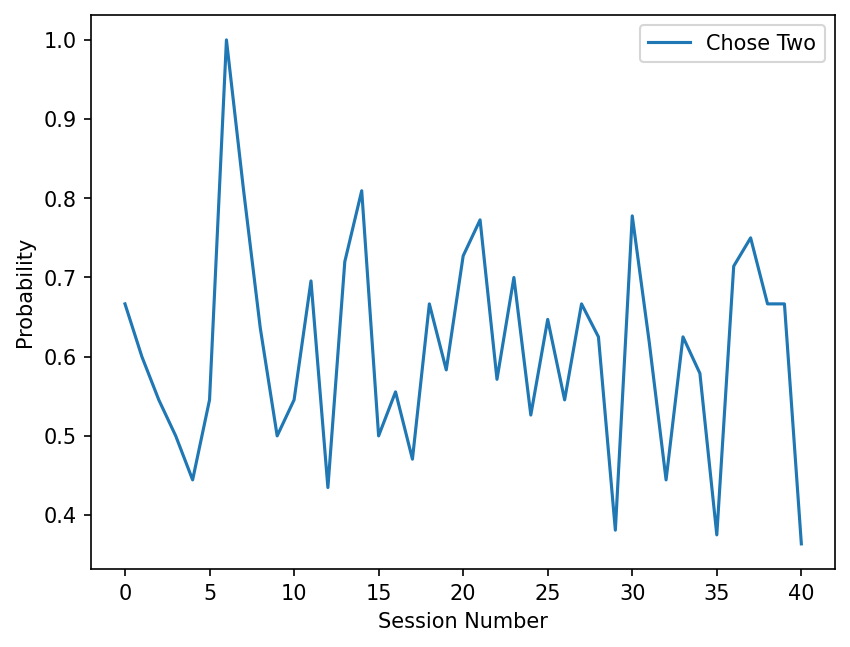

In [6]:
fig, ax = plt.subplots()
prob_chose_two = chosen_twos / has_twos
prob_chose_one = chosen_ones / has_twos
pro_chose_zero = chosen_zeros / has_twos
ax.plot(np.arange(len(sessions)), prob_chose_two, label="Chose Two")
ax.set_xlabel("Session Number")
ax.set_ylabel("Probability")
ax.legend()

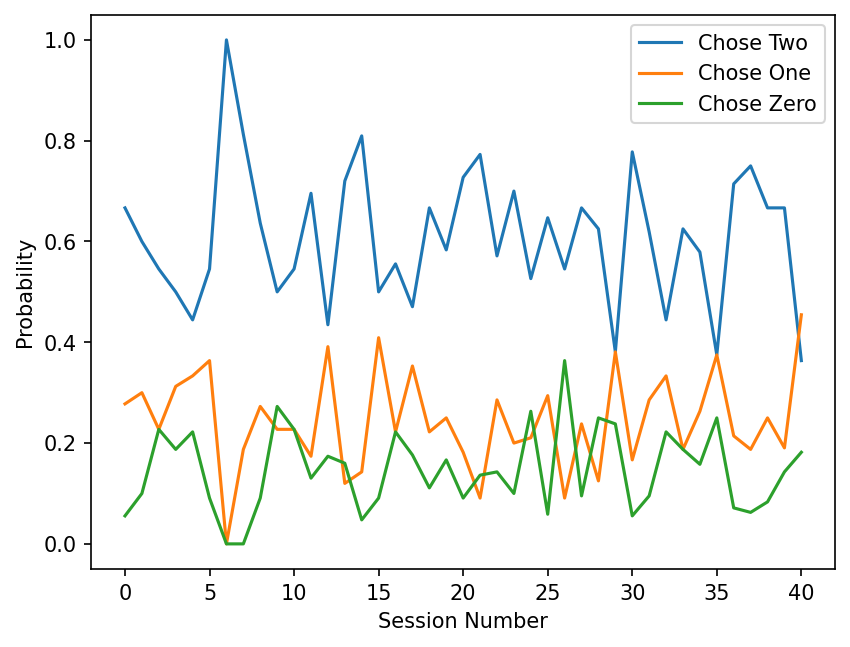

In [7]:
fig, ax = plt.subplots()
prob_chose_two = chosen_twos / has_twos
prob_chose_one = chosen_ones / has_twos
pro_chose_zero = chosen_zeros / has_twos
ax.plot(np.arange(len(sessions)), prob_chose_two, label="Chose Two")
ax.plot(np.arange(len(sessions)), prob_chose_one, label="Chose One")
ax.plot(np.arange(len(sessions)), pro_chose_zero, label="Chose Zero")
ax.set_xlabel("Session Number")
ax.set_ylabel("Probability")
ax.legend()

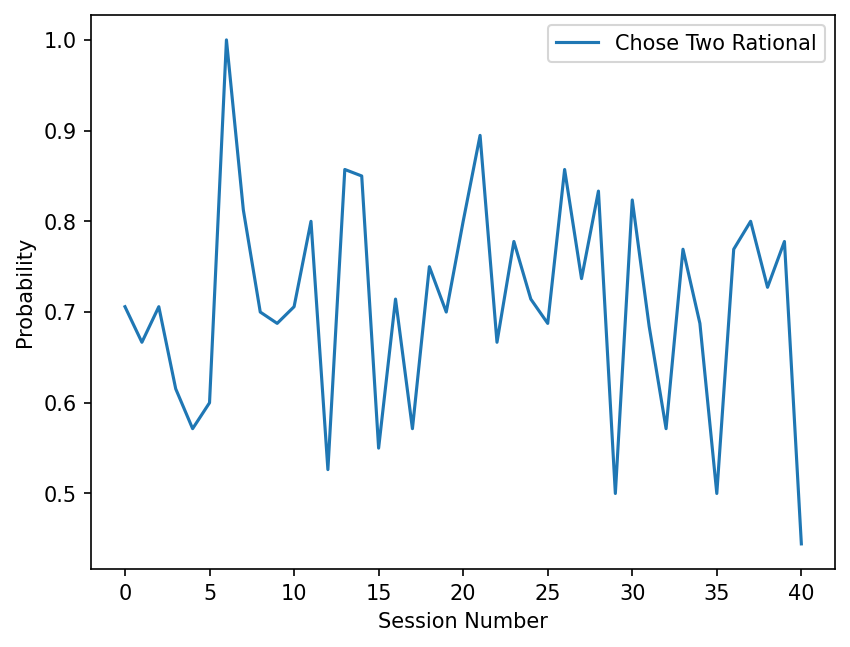

In [8]:
fig, ax = plt.subplots()
prob_chose_two_rational = chosen_twos / (chosen_twos + chosen_ones)
ax.plot(np.arange(len(sessions)), prob_chose_two_rational, label="Chose Two Rational")
ax.set_xlabel("Session Number")
ax.set_ylabel("Probability")
ax.legend()

In [9]:
print(np.sum(chosen_twos) / np.sum(has_twos))

0.6101231190150479


In [10]:
print(np.sum(chosen_twos) / (np.sum(chosen_twos) + np.sum(chosen_ones)))

SyntaxError: unexpected EOF while parsing (1542258024.py, line 1)

In [27]:
print(np.sum(chosen_twos) / np.sum(has_twos))

0.629059829059829


In [16]:
session = "20180802"
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]  

In [17]:
valid_beh

,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,LastRule,...,Item0Pattern,Item1Shape,Item1Color,Item1Pattern,Item2Shape,Item2Color,Item2Pattern,Item3Shape,Item3Color,Item3Pattern
0,0,0,0,NaN,5276,Correct,0.0,1,RIPPLE,NaN,...,RIPPLE,STAR,GREEN,POLKADOT,CIRCLE,CYAN,ESCHER,SQUARE,MAGENTA,SWIRL
1,1,0,1,NaN,5628,Correct,0.0,1,RIPPLE,NaN,...,RIPPLE,STAR,MAGENTA,POLKADOT,TRIANGLE,YELLOW,ESCHER,CIRCLE,GREEN,SWIRL
2,2,0,2,NaN,5752,Correct,0.0,1,RIPPLE,NaN,...,RIPPLE,TRIANGLE,MAGENTA,POLKADOT,STAR,CYAN,ESCHER,CIRCLE,YELLOW,SWIRL
3,3,0,3,NaN,5691,Correct,0.0,1,RIPPLE,NaN,...,RIPPLE,STAR,MAGENTA,POLKADOT,CIRCLE,GREEN,ESCHER,TRIANGLE,CYAN,SWIRL
4,4,0,4,NaN,5523,Correct,0.0,1,RIPPLE,NaN,...,RIPPLE,CIRCLE,YELLOW,POLKADOT,SQUARE,GREEN,ESCHER,TRIANGLE,CYAN,SWIRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,1745,55,2,NaN,3908,Correct,0.0,6,YELLOW,GREEN,...,POLKADOT,CIRCLE,CYAN,SWIRL,TRIANGLE,MAGENTA,RIPPLE,STAR,GREEN,ESCHER
1746,1746,55,3,NaN,3520,Incorrect,2.0,6,YELLOW,GREEN,...,RIPPLE,CIRCLE,CYAN,ESCHER,SQUARE,MAGENTA,POLKADOT,STAR,GREEN,SWIRL
1747,1747,55,4,NaN,3711,Correct,0.0,6,YELLOW,GREEN,...,SWIRL,SQUARE,CYAN,RIPPLE,STAR,MAGENTA,ESCHER,TRIANGLE,GREEN,POLKADOT
1748,1748,55,5,NaN,3524,Incorrect,1.0,6,YELLOW,GREEN,...,RIPPLE,CIRCLE,CYAN,SWIRL,STAR,MAGENTA,POLKADOT,SQUARE,GREEN,ESCHER
